In [181]:
# Cargamos las librerias necesarias para el desarrollo del ETL.
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [182]:
# Leemos los archivos csv.
df_reviews = pd.read_csv('./DATA/DATA PROCESADA/df_reviews_final.csv')
df_items = pd.read_csv('./DATA/DATA PROCESADA/df_items_final.csv')
df_games = pd.read_csv('./DATA/DATA PROCESADA/df_games_final.csv')


In [183]:
df_games['title'] = df_games['title'].astype(str)
df_items['item_name'] = df_items['item_name'].astype(str)


In [184]:
title = ' '.join(df_games['title'])
item_name = ' '.join(df_items['item_name'])

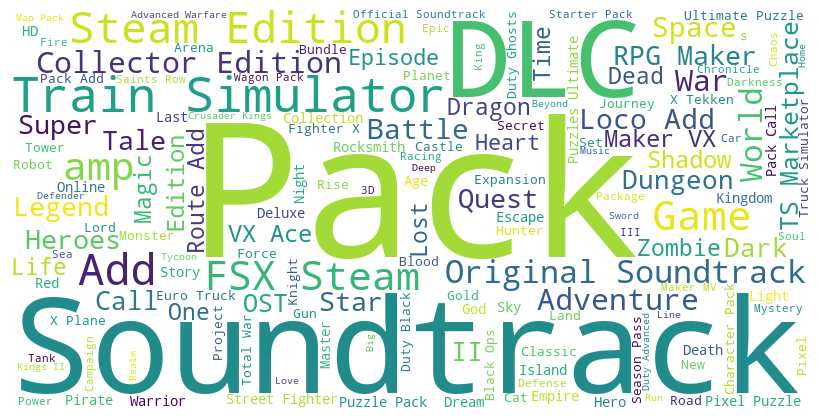

In [185]:
# Mostrar el wordcloud del titulo de los juegos.
word_cloud = WordCloud(width=800, height=400, background_color='white', min_font_size=10).generate(title)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

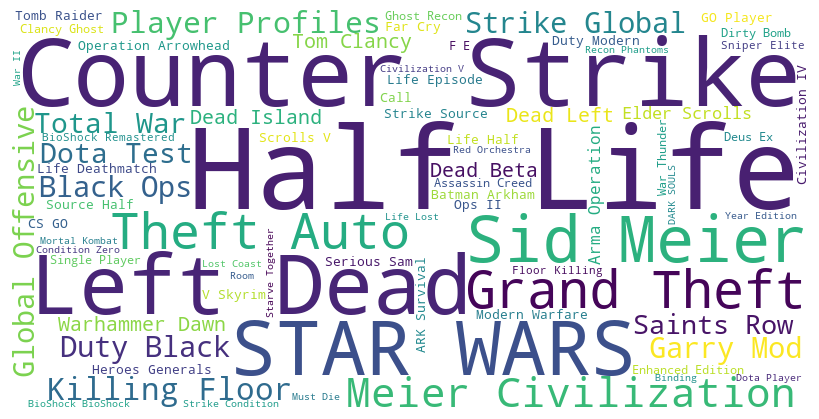

In [186]:
# Mostramos el wordcloud de los items.
word_cloud = WordCloud(width=800, height=400, background_color='white', min_font_size=10).generate(item_name)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

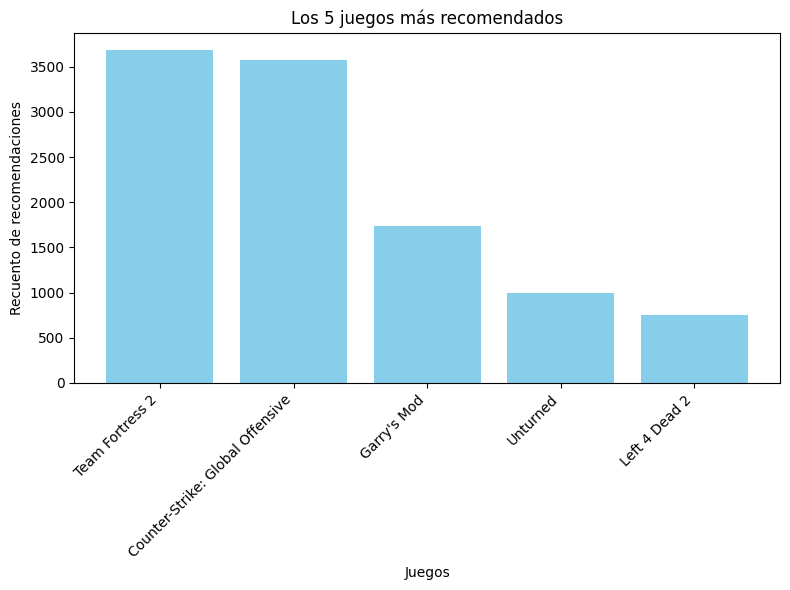

In [187]:
# Muestrame los 5 juegos mas recomendados.
df_reviews = df_reviews[df_reviews['recommend']]
recomendaciones = df_reviews.groupby('item_id')['recommend'].count().sort_values(ascending=False).head(7) # Ponemos 7 para que nos muestre 5 juegos.
top5 = pd.merge(recomendaciones, df_games[['id', 'app_name']], left_on='item_id', right_on='id')

# Graficamos los 5 juegos mas recomendados para una mejor visualizacion.
plt.figure(figsize=(8, 6))
plt.bar(top5['app_name'], top5['recommend'], color='skyblue')
plt.title('Los 5 juegos más recomendados')
plt.xlabel('Juegos')
plt.ylabel('Recuento de recomendaciones')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

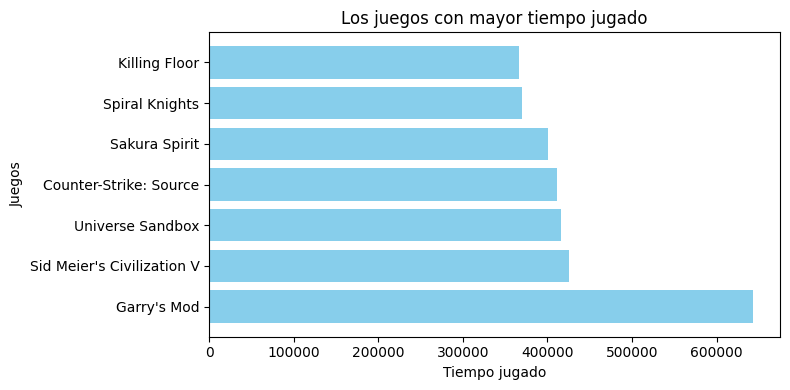

In [188]:
# Mostramos los juegos con mayor tiempo jugado.
mayor_tiempo = df_items.sort_values(by='playtime_forever', ascending=False).head(10)

# Graficamos los juegos con mayor tiempo jugado para una mejor visualizacion.
plt.figure(figsize=(8, 4))
plt.barh(mayor_tiempo['item_name'], mayor_tiempo['playtime_forever'], color='skyblue')
plt.title('Los juegos con mayor tiempo jugado')
plt.xlabel('Tiempo jugado')
plt.ylabel('Juegos')
plt.tight_layout()
plt.show()

In [189]:
# Mostramos la cantidad de juegos lanzados por mes.
df_games_copia = df_games.copy()
df_games_copia['release_date'] = pd.to_datetime(df_games_copia['release_date'], errors='coerce')
df_games_copia['release_month'] = df_games_copia['release_date'].dt.to_period('M')
cantidad_juegos_mes = df_games_copia.groupby('release_month').size().reset_index(name='Cantidad de juegos')
cantidad_juegos_mes.head()

,release_month,Cantidad de juegos
0,1983-06,1
1,1984-04,1
2,1984-11,1
3,1985-01,1
4,1986-05,1


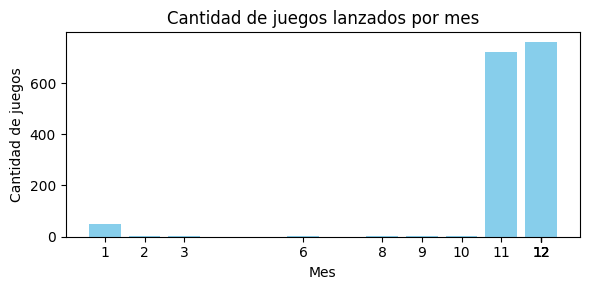

In [190]:
last_year = cantidad_juegos_mes.tail(12)
plt.figure(figsize=(6, 3))
mes = last_year['release_month'].dt.month.astype(int)
cantidad_juegos_mes = last_year['Cantidad de juegos']
plt.bar(mes, cantidad_juegos_mes, color='skyblue')
plt.title('Cantidad de juegos lanzados por mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de juegos')
plt.xticks(mes)
plt.tight_layout()
plt.show()

In [191]:
# Mostramos en que año se lanzaron mas juegos.
df_games_copia = df_games.copy()    
df_games_copia['release_date'] = pd.to_datetime(df_games_copia['release_date'], errors='coerce')
df_games_copia['release_year'] = df_games_copia['release_date'].dt.to_period('Y')
cantidad_juegos_año = df_games_copia.groupby('release_year').size().reset_index(name='Cantidad de juegos')
cantidad_juegos_año.head()


,release_year,Cantidad de juegos
0,1983,1
1,1984,2
2,1985,1
3,1986,1
4,1987,4


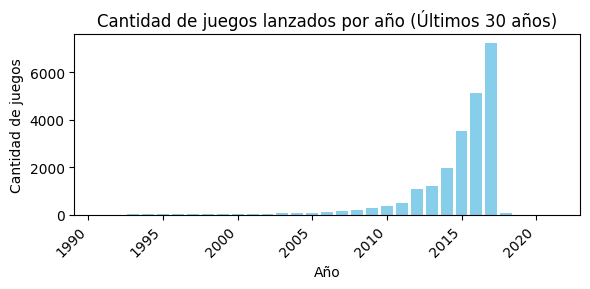

In [192]:
# Mostramos los ultimos 30 años.
last_year = cantidad_juegos_año.tail(30)
# Crear un gráfico de barras
plt.figure(figsize=(6, 3))  # Aumenta el tamaño de la figura para hacerlo más legible
año = last_year['release_year'].dt.year.astype(int)
cantidad_juegos_año = last_year['Cantidad de juegos']
plt.bar(año, cantidad_juegos_año, color='skyblue')
plt.title('Cantidad de juegos lanzados por año (Últimos 30 años)')  # Agrega un título informativo
plt.xlabel('Año')
plt.ylabel('Cantidad de juegos')
plt.xticks(rotation=45, ha='right')  # Rota las etiquetas del eje x para mayor legibilidad
plt.tight_layout()

# Mostrar el gráfico
plt.show()


Modelo de aprendizaje automático: Sistema de recomendación.

Creamos las funciones.

Función 1:  def PlayTimeGenre(genero : str): Debe devolver año con mas horas jugadas para dicho género.
                    Ejemplo de retorno: {"Año de lanzamiento con más horas jugadas para Género X" : 2013}
                        - Para esta función, necesitamos las columnas 'genres', 'year' y 'playtime_forever'. Para ello, creamos un nuevo dataframe con estas columnas, uniendo los dos dataframes que tenemos.

In [193]:
# Unimos los dataframes df_games y df_items.
df_games_items = pd.merge(df_games, df_items, left_on='id', right_on='item_id')
df_games_items.head()

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer,user_id,items_count,steam_id,user_url,item_id,item_name,playtime_forever
0,Stainless Games Ltd,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,Carmageddon Max Pack,http://store.steampowered.com/app/282010/Carma...,1997-06-30,"['Racing', 'Action', 'Classic', 'Indie', 'Gore...",http://steamcommunity.com/app/282010/reviews/?...,"['Single-player', 'Multi-player', 'Steam Tradi...",9.99,0,282010,Stainless Games Ltd,UTNerd24,188,76561198053985682,http://steamcommunity.com/id/UTNerd24,282010,Carmageddon Max Pack,5
1,Stainless Games Ltd,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,Carmageddon Max Pack,http://store.steampowered.com/app/282010/Carma...,1997-06-30,"['Racing', 'Action', 'Classic', 'Indie', 'Gore...",http://steamcommunity.com/app/282010/reviews/?...,"['Single-player', 'Multi-player', 'Steam Tradi...",9.99,0,282010,Stainless Games Ltd,I_DID_911_JUST_SAYING,154,76561198067520555,http://steamcommunity.com/id/I_DID_911_JUST_SA...,282010,Carmageddon Max Pack,0
2,Stainless Games Ltd,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,Carmageddon Max Pack,http://store.steampowered.com/app/282010/Carma...,1997-06-30,"['Racing', 'Action', 'Classic', 'Indie', 'Gore...",http://steamcommunity.com/app/282010/reviews/?...,"['Single-player', 'Multi-player', 'Steam Tradi...",9.99,0,282010,Stainless Games Ltd,76561197962104795,79,76561197962104795,http://steamcommunity.com/profiles/76561197962...,282010,Carmageddon Max Pack,0
3,Stainless Games Ltd,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,Carmageddon Max Pack,http://store.steampowered.com/app/282010/Carma...,1997-06-30,"['Racing', 'Action', 'Classic', 'Indie', 'Gore...",http://steamcommunity.com/app/282010/reviews/?...,"['Single-player', 'Multi-player', 'Steam Tradi...",9.99,0,282010,Stainless Games Ltd,r3ap3r78,331,76561198011684252,http://steamcommunity.com/id/r3ap3r78,282010,Carmageddon Max Pack,0
4,Stainless Games Ltd,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,Carmageddon Max Pack,http://store.steampowered.com/app/282010/Carma...,1997-06-30,"['Racing', 'Action', 'Classic', 'Indie', 'Gore...",http://steamcommunity.com/app/282010/reviews/?...,"['Single-player', 'Multi-player', 'Steam Tradi...",9.99,0,282010,Stainless Games Ltd,saint556,583,76561198072532181,http://steamcommunity.com/id/saint556,282010,Carmageddon Max Pack,13


In [194]:
# Obtenemos las columnas genres, year y playtime_forever y las guardamos en un nuevo dataframe.
df_games_items = df_games_items[['genres', 'release_date', 'playtime_forever', 'user_id']]
df_games_items.head()

# Guardamos el dataframe en un archivo csv.
df_games_items.to_csv('./DATA API/df_games_items.csv', index=False)

In [195]:
def PlayTimeGenre(genero, df):
    # Filtrar el DataFrame por el género especificado
    df_genre = df[df['genres'].str.lower().str.contains(genero)]

    if df_genre.empty:
        return f"No hay datos disponibles para el género {genero}"

    # Hacer una copia del DataFrame filtrado
    df_genre = df_genre.copy()

    # Convierte la columna 'release_date' en tipo datetime
    df_genre['release_date'] = pd.to_datetime(df_genre['release_date'], format='%Y-%m-%d', errors='coerce')

    # Extraer el año de la columna 'release_date'
    df_genre['release_year'] = df_genre['release_date'].dt.year

    # Agrupar por año y calcular las horas jugadas totales
    result = df_genre.groupby(df_genre['release_year'])['playtime_forever'].sum()

    # Encontrar el año con más horas jugadas
    max_year = result.idxmax()

    return {f"Año de lanzamiento con más horas jugadas para Género {genero}": max_year}

In [196]:
# Hacemos una prueba de la funcion 1.
genero = 'action'
resultado = PlayTimeGenre(genero, df_games_items)
print(resultado)

{'Año de lanzamiento con más horas jugadas para Género action': 2012}


Función 2:  def UserForGenre( genero : str ): Debe devolver el usuario que acumula más horas jugadas para el género dado y una lista
            de la acumulación de horas jugadas por año.
                    Ejemplo de retorno: {"Usuario con más horas jugadas para Género X" : us213ndjss09sdf, "Horas jugadas":[{Año: 2013, Horas: 203}, {Año: 2012, Horas: 100}, {Año: 2011, Horas: 23}]}

In [197]:
def UserForGenre(genero, df):
    # Filtrar el DataFrame por el género especificado
    df_genre = df[df['genres'].str.lower().str.contains(genero)]

    if df_genre.empty:
        return {
            f"Usuario con más horas jugadas para Género {genero}": None,
            "Horas jugadas": []
        }

    # Hacer una copia del DataFrame filtrado
    df_genre = df_genre.copy()

    # Convierte la columna 'release_date' en tipo datetime
    df_genre['release_date'] = pd.to_datetime(df_genre['release_date'], format='%Y-%m-%d', errors='coerce')

    # Extraer el año de la columna 'release_date'
    df_genre['release_year'] = df_genre['release_date'].dt.year

    # Agrupar por usuario y año, calcular las horas jugadas totales
    result = df_genre.groupby(['user_id', df_genre['release_year']])['playtime_forever'].sum().reset_index()

    # Encontrar al usuario con más horas jugadas para el género
    max_user = result.loc[result.groupby('user_id')['playtime_forever'].idxmax()]
    max_user_id = max_user['user_id'].values[0]

    # Calcular la acumulación de horas jugadas por año
    total_hours_by_year = result.groupby('release_year')['playtime_forever'].sum().reset_index()
    
    # Crear la lista de acumulación de horas jugadas por año en el formato deseado
    horas_por_ano = [{"Año": int(row['release_year']), "Horas": int(row['playtime_forever'])} for _, row in total_hours_by_year.iterrows()]

    return {
        f"Usuario con más horas jugadas para Género {genero}": max_user_id,
        "Horas jugadas": horas_por_ano
    }

In [198]:
# Hacemos una prueba de la funcion 2.
genero = 'action'
resultado = UserForGenre(genero, df_games_items)
print(resultado)


{'Usuario con más horas jugadas para Género action': '-AnimeIsMyThing-', 'Horas jugadas': [{'Año': 1983, 'Horas': 954}, {'Año': 1984, 'Horas': 109}, {'Año': 1988, 'Horas': 2851}, {'Año': 1989, 'Horas': 48}, {'Año': 1990, 'Horas': 3702}, {'Año': 1991, 'Horas': 81}, {'Año': 1992, 'Horas': 350}, {'Año': 1993, 'Horas': 5738}, {'Año': 1994, 'Horas': 26137}, {'Año': 1995, 'Horas': 34355}, {'Año': 1996, 'Horas': 19018}, {'Año': 1997, 'Horas': 76755}, {'Año': 1998, 'Horas': 456830}, {'Año': 1999, 'Horas': 522228}, {'Año': 2000, 'Horas': 2743503}, {'Año': 2001, 'Horas': 176016}, {'Año': 2002, 'Horas': 111000}, {'Año': 2003, 'Horas': 2133592}, {'Año': 2004, 'Horas': 15944825}, {'Año': 2005, 'Horas': 1873782}, {'Año': 2006, 'Horas': 1886869}, {'Año': 2007, 'Horas': 2945225}, {'Año': 2008, 'Horas': 5410848}, {'Año': 2009, 'Horas': 25057978}, {'Año': 2010, 'Horas': 33766785}, {'Año': 2011, 'Horas': 56322822}, {'Año': 2012, 'Horas': 192125958}, {'Año': 2013, 'Horas': 89780639}, {'Año': 2014, 'Horas'

Función 3:  def UsersRecommend( año : int ): Devuelve el top 3 de juegos MÁS recomendados por usuarios para el año dado. 
            (reviews.recommend = True y comentarios positivos/neutrales)
                    Ejemplo de retorno: [{"Puesto 1" : X}, {"Puesto 2" : Y},{"Puesto 3" : Z}]
                        - Para esta función, necesitamos las columnas 'poster', 'recommend' y 'app_name'. Para ello, creamos un nuevo dataframe con estas columnas, uniendo los dos dataframes que tenemos.

In [199]:
# Unimos los dataframes df_games y df_reviews
df_games_reviews = pd.merge(df_games, df_reviews, left_on='id', right_on='item_id')
# Obtenemos las columnas user_id, posted, recommended, app_name y los guardamos en un nuevo dataframe.
df_games_reviews = df_games_reviews[['posted', 'recommend', 'app_name']]
df_games_reviews.to_csv('./DATA API/df_games_reviews.csv', index=False)


In [200]:
def UsersRecommend(año: int, df):
    # Filtrar el DataFrame por el año especificado y reseñas recomendadas (recommend = True)
    reviews_filtered = df_games_reviews[(df_games_reviews['posted'].str[:4] == str(año)) & (df_games_reviews['recommend'] == True)]

    # Contar las reseñas de cada juego
    game_counts = reviews_filtered['app_name'].value_counts().reset_index()
    game_counts.columns = ['Juego', 'Total Reseñas']

    # Ordenar los juegos por la cantidad de reseñas en orden descendente
    game_counts = game_counts.sort_values(by='Total Reseñas', ascending=False)

    # Tomar los 3 juegos más recomendados
    top_3_games = game_counts.head(3)

    # Crear la lista de retorno en el formato deseado
    result = [{"Puesto " + str(i + 1): game} for i, game in enumerate(top_3_games['Juego'])]

    return result

In [201]:
# Hacemos una prueba de la funcion 3.
año_deseado = 2011  # Cambia el año según tus necesidades
resultado = UsersRecommend(año_deseado, df_games_reviews)
print(resultado)

[{'Puesto 1': 'Team Fortress 2'}, {'Puesto 2': 'Portal 2'}, {'Puesto 3': 'Terraria'}]


Función 4:  def UsersNotRecommend( año : int ): Devuelve el top 3 de juegos MENOS recomendados por usuarios para el año dado.
            (reviews.recommend = False y comentarios negativos)
                    Ejemplo de retorno: [{"Puesto 1" : X}, {"Puesto 2" : Y},{"Puesto 3" : Z}]

In [202]:
df_reviews_final = pd.read_csv('./DATA/DATA PROCESADA/df_reviews_final.csv')
df_games_reviews_false = pd.merge(df_reviews_final, df_games, left_on='item_id', right_on='id')
df_games_reviews_false.to_csv('./DATA API/df_games_reviews_false.csv', index=False)

In [203]:
def UsersRecommend(año: int, df):
    # Filtrar el DataFrame por el año especificado y reseñas recomendadas (recommend = False)
    reviews_filtered = df_games_reviews_false[(df_games_reviews_false['posted'].str[:4] == str(año)) & (df_games_reviews_false['recommend'] == False)]

    # Contar las reseñas de cada juego
    game_counts = reviews_filtered['app_name'].value_counts().reset_index()
    game_counts.columns = ['Juego', 'Total Reseñas']

    # Ordenar los juegos por la cantidad de reseñas en orden descendente
    game_counts = game_counts.sort_values(by='Total Reseñas', ascending=False)

    # Tomar los 3 juegos más recomendados
    top_3_games = game_counts.head(3)

    # Crear la lista de retorno en el formato deseado
    result = [{"Puesto " + str(i + 1): game} for i, game in enumerate(top_3_games['Juego'])]

    return result

In [204]:
# Hacemos una prueba de la funcion 4.
año_deseado = 2023  # Cambia el año según tus necesidades
resultado = UsersRecommend(año_deseado, df_games_reviews)
print(resultado)

[{'Puesto 1': "No Man's Sky"}, {'Puesto 2': 'Counter-Strike: Global Offensive'}, {'Puesto 3': 'Team Fortress 2'}]


Función 5:  def sentiment_analysis( año : int ): Según el año de lanzamiento, se devuelve una lista con la cantidad de registros
            de reseñas de usuarios que se encuentren categorizados con un análisis de sentimiento.
                    Ejemplo de retorno: {Negative = 182, Neutral = 120, Positive = 278}

In [205]:
df_sentimental = df_reviews.to_csv('./DATA API/df_sentimental.csv', index=False)

In [206]:
df_sentimental = pd.read_csv('./DATA API/df_sentimental.csv')
df_sentimental.head()

,user_id,user_url,posted,item_id,recommend,sentiment_analysis
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,2011-11-05,1250,True,1
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,2011-07-15,22200,True,1
2,76561197970982479,http://steamcommunity.com/profiles/76561197970...,2011-04-21,43110,True,1
3,js41637,http://steamcommunity.com/id/js41637,2014-06-24,251610,True,1
4,js41637,http://steamcommunity.com/id/js41637,2013-09-08,227300,True,1


In [207]:
def sentiment_analysis(df, year):
    # Filtra el DataFrame para obtener solo las reseñas del año especificado
    reviews_by_year = df[df['posted'].str.startswith(str(year))]
    
    # Cuenta la cantidad de registros en cada categoría de análisis de sentimiento
    sentiment_counts = reviews_by_year['sentiment_analysis'].value_counts().to_dict()
    
    # Mapea los valores numéricos a las etiquetas deseadas y define el orden
    sentiment_dict = {
        'Negative': sentiment_counts.get(0, 0),
        'Neutral': sentiment_counts.get(1, 0),
        'Positive': sentiment_counts.get(2, 0)
    }
    
    return sentiment_dict

In [208]:
year = 2010 # Cambia el año según tus necesidades
result = sentiment_analysis(df_sentimental, year)
print(result)

{'Negative': 6, 'Neutral': 36, 'Positive': 23}


Sistema de recomendacion.

In [209]:
sample_size = 100
random_sample = df_games.sample(sample_size, random_state=42)

In [210]:
user_item_id = 100 # id del juego que queremos recomendar
target_game = random_sample[random_sample["id"]==user_item_id]

target_game_tags_and_genres= "".join(target_game["tags"].fillna("").astype(str)+""+ target_game["genres"].fillna("").astype(str))

tfidf_vectorizer = TfidfVectorizer()

random_sample["tags_and_genres"]= random_sample["tags"].fillna("").astype(str) +""+ random_sample["genres"].fillna("").astype(str)
tfidf_matrix = tfidf_vectorizer.fit_transform([target_game_tags_and_genres]+ random_sample["tags_and_genres"].tolist())

similatary_matrix = cosine_similarity(tfidf_matrix)

similar_games_indices = similatary_matrix[0].argsort()[::-1]

num_recomendation = 5
recomended_games = random_sample.reset_index(drop=True).loc[similar_games_indices[1: num_recomendation + 1 ]]

recomended_games

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer,tags_and_genres
36,Beyond Technical,"['Action', 'Adventure', 'Indie']",Super Robot Jump Jump,Super Robot Jump Jump,http://store.steampowered.com/app/422980/Super...,2016-03-31,"['Action', 'Adventure', 'Indie', 'Platformer',...",http://steamcommunity.com/app/422980/reviews/?...,"['Single-player', 'Multi-player', 'Co-op', 'Sh...",4.99,0,422980,Beyond Technical Inc.,"['Action', 'Adventure', 'Indie', 'Platformer',..."
26,Leaghorn,"['Casual', 'Indie', 'Strategy']",Matris,Matris,http://store.steampowered.com/app/470440/Matris/,2016-06-02,"['Indie', 'Casual', 'Strategy']",http://steamcommunity.com/app/470440/reviews/?...,"['Single-player', 'Steam Achievements', 'Full ...",4.99,0,470440,Leaghorn,"['Indie', 'Casual', 'Strategy']['Casual', 'Ind..."
27,Positech Games,"['Indie', 'Simulation', 'Strategy']",Democracy 3: Extremism,Democracy 3: Extremism,http://store.steampowered.com/app/291900/Democ...,2014-05-13,"['Simulation', 'Strategy', 'Indie']",http://steamcommunity.com/app/291900/reviews/?...,"['Single-player', 'Downloadable Content', 'Ste...",4.99,0,291900,Positech Games,"['Simulation', 'Strategy', 'Indie']['Indie', '..."
28,Psychic Software,"['Casual', 'Indie', 'Massively Multiplayer', '...",Musclecar Online,Musclecar Online,http://store.steampowered.com/app/346440/Muscl...,2015-02-12,"['Racing', 'Indie', 'Casual', 'Massively Multi...",http://steamcommunity.com/app/346440/reviews/?...,"['Multi-player', 'MMO', 'Cross-Platform Multip...",5.99,0,346440,Psychic Software,"['Racing', 'Indie', 'Casual', 'Massively Multi..."
29,Clarus Victoria,"['Casual', 'Indie', 'Simulation', 'Strategy']",Bronze Age - HD Edition,Bronze Age - HD Edition,http://store.steampowered.com/app/686900/Bronz...,2013-09-10,"['Strategy', 'Indie', 'Simulation', 'Atmospher...",http://steamcommunity.com/app/686900/reviews/?...,"['Single-player', 'Steam Achievements', 'Steam...",2.99,0,686900,Clarus Victoria,"['Strategy', 'Indie', 'Simulation', 'Atmospher..."
